In [1]:
#####################################################
# Author: Prof. Marc Jofre
# Dept. Network Engineering
# Universitat Politècnica de Catalunya - Technical University of Catalonia
#
# Modified: 2024
# Created: 2024
#
# Script Quantum LAN application Dealer layer
#####################################################
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>") # Restart the kernel to clean up previous
#####################################################
import sys, os, signal
#!pip install --upgrade pip
#!pip install --upgrade pillow
#!pip install matplotlib
#!pip install numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from google.colab import files
#print(plt.style.available)
mpl.style.use('default')
import time

pathScriptBelowAgentScript='./CppScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptBelowAgentScript='./JupyterPythonScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptData='../../GeneratedDataPythonJupyter/'

In [2]:
import QpresentationLayerAgent

#####################################################
# Parameters
## Network
IPhostDealerOpNet = "127.0.0.3"#10.0.0.4" # IP address of the dealer host (this host) in the operational network
IPhostDealerConNet = "192.168.10.1" # IP address of the dealer host (this host) in the control/configuration network
IPnodeDealerConNet = "192.168.10.2" # IP address of the dealer node (connected to the dealer host) in the control/configuration network
IPhostServerOpNet = "127.0.0.2"#"10.0.0.3" # IP address of the server host (this host) in the operational network
IPnodeServerConNet = "192.168.9.2" # IP address of the server node (connected to the server host) in the control/configuration network
IPhostClientOpNet = "127.0.0.1"#"10.0.0.1" # IP address of the host client (connected to the server host) in the operational network
IPnodeClientConNet = "192.168.8.2" # IP address of the client node (connecte to the client host) in the control/configuration network

ParamsDealerListChar = ["dealer",IPnodeDealerConNet,IPhostDealerConNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostClientOpNet]

##############################################################
# Functions
def ListCharArrayParser(ListCharArrayAux):
    # Actually concatenating a python list of strings to a single string
    ParsedCharArrayAux=",".join(ListCharArrayAux)+","
    return ParsedCharArrayAux

# The parameters passed and received from agents are structured
ParamsAscendingCharArray = "none"
ParamsDescendingCharArray = ListCharArrayParser(ParamsDealerListChar)

### RUN UP TO HERE (INCLUDED) TO INITIALIZE CONNECTIONS AND THREAD QtransportLayerAgentH thread #####
# At this point, in this order, the node in the server has been initialized, the node in the client, the server host (up to this equivalent point) and then the client host (up to here)
# Create instance of Agent below
QPLAagent = QpresentationLayerAgent.QPLA(ParamsDescendingCharArray,ParamsAscendingCharArray)
def signal_handler(signal_received,frame):
    print(f'Signal {signal_received} received, exiting gracefully.')
    # Perform any cleanup here
    del QPLAagent
    sys.exit(0)

# Set up signal handlers
signal.signal(signal.SIGINT, signal_handler)  # Handle Ctrl+C
signal.signal(signal.SIGPIPE, signal_handler) # Handle broken pipe errors
#signal.signal(signal.SIGSEGV, signal_handler) # Handle segmentation faults (typically memory errors)
signal.signal(signal.SIGHUP, signal_handler) # Handle when terminal window is closed
signal.signal(signal.SIGTERM, signal_handler) # Termination request
### Initiate thread process in QtransportLayerAgentH
QPLAagent.InitAgentProcess() # Initialize the thread in QtransportLayerAgentH

In [ ]:
#####################
# Some tests to send information to the different elements and see them output at the respective console
# The required fields of a message are (separated by commas): IPdestination,IPorigin,Type,Command,Payload
messagePayloadAux="Host dealer sends information to attached node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPnodeDealerConNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to server host"
messageCommandAux="print"
messageTypeAux="Operation"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostServerOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to host server node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to client host"
messageCommandAux="print"
messageTypeAux="Operation"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostClientOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host dealer sends information to host client node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostDealerOpNet
messageIPdest=IPhostClientOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

In [ ]:
#### Some test to send entangled QuBits from the dealer to two other hosts #################
QPLAagent.SimulateSendEntangledQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,128) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
NumStoredQubitsNode1 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
StatisticsTimeTagDetStoredQubitsNode1 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostClientOpNet,IPhostDealerOpNet,NumStoredQubitsNode1,StatisticsTimeTagDetStoredQubitsNode1) # Supposing that node has received quBits, return number of QuBits
print('NumStoredQubitsNode1[0]: '+str(NumStoredQubitsNode1[0]))
print('StatisticsTimeTagDetStoredQubitsNode1: '+str(StatisticsTimeTagDetStoredQubitsNode1))
NumStoredQubitsNode2 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
StatisticsTimeTagDetStoredQubitsNode2 = np.zeros(8, dtype=np.double)# equivalnet to float64for C like arrays
QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostServerOpNet,IPhostDealerOpNet,NumStoredQubitsNode2,StatisticsTimeTagDetStoredQubitsNode2) # Supposing that node has received quBits, return number of QuBits
print('NumStoredQubitsNode2[0]: '+str(NumStoredQubitsNode2[0]))
print('StatisticsTimeTagDetStoredQubitsNode2: '+str(StatisticsTimeTagDetStoredQubitsNode2))

In [ ]:
###### Hard resilience test #######
import random
import time
NumTestMax = 1000
ListNumStoredQubitsNode1=[]
ListStatisticsTimeTaggDetQubitsNode1Param0=[]
ListStatisticsTimeTaggDetQubitsNode1Param1=[]
ListStatisticsTimeTaggDetQubitsNode1Param2=[]
ListStatisticsTimeTaggDetQubitsNode1Param3=[]
ListStatisticsTimeTaggDetQubitsNode1Param4=[]
ListStatisticsTimeTaggDetQubitsNode1Param5=[]
ListStatisticsTimeTaggDetQubitsNode1Param6=[]
ListStatisticsTimeTaggDetQubitsNode1Param7=[]
ListNumStoredQubitsNode2=[]
ListStatisticsTimeTaggDetQubitsNode2Param0=[]
ListStatisticsTimeTaggDetQubitsNode2Param1=[]
ListStatisticsTimeTaggDetQubitsNode2Param2=[]
ListStatisticsTimeTaggDetQubitsNode2Param3=[]
ListStatisticsTimeTaggDetQubitsNode2Param4=[]
ListStatisticsTimeTaggDetQubitsNode2Param5=[]
ListStatisticsTimeTaggDetQubitsNode2Param6=[]
ListStatisticsTimeTaggDetQubitsNode2Param7=[]
for iIterTest in range(0,NumTestMax,1):
    RandomTestNum=random.randint(0, 1)
    if (RandomTestNum==0):
        # Sending messages
        messagePayloadAux="Host dealer sends information to attached node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPnodeDealerConNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to server host"
        messageCommandAux="print"
        messageTypeAux="Operation"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostServerOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to host server node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to client host"
        messageCommandAux="print"
        messageTypeAux="Operation"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostClientOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host dealer sends information to host client node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostDealerOpNet
        messageIPdest=IPhostClientOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)      
    else:
        # Sending Entangled QuBits
        QPLAagent.SimulateSendEntangledQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,128) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
        NumStoredQubitsNode1 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode1 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostClientOpNet,IPhostDealerOpNet,NumStoredQubitsNode1,StatisticsTimeTagDetStoredQubitsNode1) # Supposing that node has received quBits, return number of QuBits
        NumStoredQubitsNode2 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode2 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostServerOpNet,IPhostDealerOpNet,NumStoredQubitsNode2,StatisticsTimeTagDetStoredQubitsNode2) # Supposing that node has received quBits, return number of QuBits
        ListNumStoredQubitsNode1.append(NumStoredQubitsNode1[0])
        ListStatisticsTimeTaggDetQubitsNode1Param0.append(StatisticsTimeTagDetStoredQubitsNode1[0])
        ListStatisticsTimeTaggDetQubitsNode1Param1.append(StatisticsTimeTagDetStoredQubitsNode1[1])
        ListStatisticsTimeTaggDetQubitsNode1Param2.append(StatisticsTimeTagDetStoredQubitsNode1[2])
        ListStatisticsTimeTaggDetQubitsNode1Param3.append(StatisticsTimeTagDetStoredQubitsNode1[3])
        ListStatisticsTimeTaggDetQubitsNode1Param4.append(StatisticsTimeTagDetStoredQubitsNode1[4])
        ListStatisticsTimeTaggDetQubitsNode1Param5.append(StatisticsTimeTagDetStoredQubitsNode1[5])
        ListStatisticsTimeTaggDetQubitsNode1Param6.append(StatisticsTimeTagDetStoredQubitsNode1[6])
        ListStatisticsTimeTaggDetQubitsNode1Param7.append(StatisticsTimeTagDetStoredQubitsNode1[7])
        ListNumStoredQubitsNode2.append(NumStoredQubitsNode2[0])
        ListStatisticsTimeTaggDetQubitsNode2Param0.append(StatisticsTimeTagDetStoredQubitsNode2[0])
        ListStatisticsTimeTaggDetQubitsNode2Param1.append(StatisticsTimeTagDetStoredQubitsNode2[1])
        ListStatisticsTimeTaggDetQubitsNode2Param2.append(StatisticsTimeTagDetStoredQubitsNode2[2])
        ListStatisticsTimeTaggDetQubitsNode2Param3.append(StatisticsTimeTagDetStoredQubitsNode2[3])
        ListStatisticsTimeTaggDetQubitsNode2Param4.append(StatisticsTimeTagDetStoredQubitsNode2[4])
        ListStatisticsTimeTaggDetQubitsNode2Param5.append(StatisticsTimeTagDetStoredQubitsNode2[5])
        ListStatisticsTimeTaggDetQubitsNode2Param6.append(StatisticsTimeTagDetStoredQubitsNode2[6])
        ListStatisticsTimeTaggDetQubitsNode2Param7.append(StatisticsTimeTagDetStoredQubitsNode2[7])
    time.sleep(15.0)
    time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode1: '+str(ListNumStoredQubitsNode1))
print('ListStatisticsTimeTaggDetQubitsNode1Param0: '+str(ListStatisticsTimeTaggDetQubitsNode1Param0))
print('ListStatisticsTimeTaggDetQubitsNode1Param1: '+str(ListStatisticsTimeTaggDetQubitsNode1Param1))
print('ListStatisticsTimeTaggDetQubitsNode1Param2: '+str(ListStatisticsTimeTaggDetQubitsNode1Param2))
print('ListStatisticsTimeTaggDetQubitsNode1Param3: '+str(ListStatisticsTimeTaggDetQubitsNode1Param3))
print('ListStatisticsTimeTaggDetQubitsNode1Param4: '+str(ListStatisticsTimeTaggDetQubitsNode1Param4))
print('ListStatisticsTimeTaggDetQubitsNode1Param5: '+str(ListStatisticsTimeTaggDetQubitsNode1Param5))
print('ListStatisticsTimeTaggDetQubitsNode1Param6: '+str(ListStatisticsTimeTaggDetQubitsNode1Param6))
print('ListStatisticsTimeTaggDetQubitsNode1Param7: '+str(ListStatisticsTimeTaggDetQubitsNode1Param7))
print('ListNumStoredQubitsNode2: '+str(ListNumStoredQubitsNode2))
print('ListStatisticsTimeTaggDetQubitsNode2Param0: '+str(ListStatisticsTimeTaggDetQubitsNode2Param0))
print('ListStatisticsTimeTaggDetQubitsNode2Param1: '+str(ListStatisticsTimeTaggDetQubitsNode2Param1))
print('ListStatisticsTimeTaggDetQubitsNode2Param2: '+str(ListStatisticsTimeTaggDetQubitsNode2Param2))
print('ListStatisticsTimeTaggDetQubitsNode2Param3: '+str(ListStatisticsTimeTaggDetQubitsNode2Param3))
print('ListStatisticsTimeTaggDetQubitsNode2Param4: '+str(ListStatisticsTimeTaggDetQubitsNode2Param4))
print('ListStatisticsTimeTaggDetQubitsNode2Param5: '+str(ListStatisticsTimeTaggDetQubitsNode2Param5))
print('ListStatisticsTimeTaggDetQubitsNode2Param6: '+str(ListStatisticsTimeTaggDetQubitsNode2Param6))
print('ListStatisticsTimeTaggDetQubitsNode2Param7: '+str(ListStatisticsTimeTaggDetQubitsNode2Param7))

In [ ]:
# Save generated data
#print(os.getcwd())
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString,ListNumStoredQubitsNode1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param7)
np.save(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString,ListNumStoredQubitsNode2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param7)

In [ ]:
# Plot ListNumStoredQubitsNode data
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
### Node 1
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam0=np.load(pathScriptData+'DealerListNumStoredQubitsCh1Node1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam0,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch1 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam1=np.load(pathScriptData+'DealerListNumStoredQubitsCh2Node1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam1,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch2 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam2=np.load(pathScriptData+'DealerListNumStoredQubitsCh3Node1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam2,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch3 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam3=np.load(pathScriptData+'DealerListNumStoredQubitsCh4Node1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam3,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch4 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam4=np.load(pathScriptData+'DealerListNumStoredQubitsMultiNode1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Multi Ch. hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam5=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Time diff avg. [count]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Time. diff. std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7)
plt.xlabel('Det. run')
plt.ylabel('Time. abs [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

##########################################################################################################
## Node 2
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam0=np.load(pathScriptData+'DealerListNumStoredQubitsCh1Node2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam0,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch1 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam1=np.load(pathScriptData+'DealerListNumStoredQubitsCh2Node2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam1,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch2 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam2=np.load(pathScriptData+'DealerListNumStoredQubitsCh3Node2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam2,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch3 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam3=np.load(pathScriptData+'DealerListNumStoredQubitsCh4Node2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam3,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch4 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam4=np.load(pathScriptData+'DealerListNumStoredQubitsMultiNode2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Multi Ch. hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam5=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Time diff avg. [count]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Time. diff. std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7)
plt.xlabel('Det. run')
plt.ylabel('Time. abs [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

In [ ]:
####### Debbuging synch intra runs
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics in QPhysLayer c++ is modified to this particular case

In [34]:
import random
import time
NumTestMax = 5
ListNumStoredQubitsNode1=[]
ListStatisticsTimeTaggDetQubitsNode1Param0=[]
ListStatisticsTimeTaggDetQubitsNode1Param1=[]
ListStatisticsTimeTaggDetQubitsNode1Param2=[]
ListStatisticsTimeTaggDetQubitsNode1Param3=[]
ListStatisticsTimeTaggDetQubitsNode1Param4=[]
ListStatisticsTimeTaggDetQubitsNode1Param5=[]
ListStatisticsTimeTaggDetQubitsNode1Param6=[]
ListStatisticsTimeTaggDetQubitsNode1Param7=[]
ListNumStoredQubitsNode2=[]
ListStatisticsTimeTaggDetQubitsNode2Param0=[]
ListStatisticsTimeTaggDetQubitsNode2Param1=[]
ListStatisticsTimeTaggDetQubitsNode2Param2=[]
ListStatisticsTimeTaggDetQubitsNode2Param3=[]
ListStatisticsTimeTaggDetQubitsNode2Param4=[]
ListStatisticsTimeTaggDetQubitsNode2Param5=[]
ListStatisticsTimeTaggDetQubitsNode2Param6=[]
ListStatisticsTimeTaggDetQubitsNode2Param7=[]
for iIterTest in range(0,NumTestMax,1):
    # Sending Entangled QuBits
    QPLAagent.SimulateSendEntangledQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,128) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
    NumStoredQubitsNode1 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode1 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostClientOpNet,IPhostDealerOpNet,NumStoredQubitsNode1,StatisticsTimeTagDetStoredQubitsNode1) # Supposing that node has received quBits, return number of QuBits
    NumStoredQubitsNode2 = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode2 = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPhostServerOpNet,IPhostDealerOpNet,NumStoredQubitsNode2,StatisticsTimeTagDetStoredQubitsNode2) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode1.append(NumStoredQubitsNode1[0])
    ListStatisticsTimeTaggDetQubitsNode1Param0.append(StatisticsTimeTagDetStoredQubitsNode1[0])
    ListStatisticsTimeTaggDetQubitsNode1Param1.append(StatisticsTimeTagDetStoredQubitsNode1[1])
    ListStatisticsTimeTaggDetQubitsNode1Param2.append(StatisticsTimeTagDetStoredQubitsNode1[2])
    ListStatisticsTimeTaggDetQubitsNode1Param3.append(StatisticsTimeTagDetStoredQubitsNode1[3])
    ListStatisticsTimeTaggDetQubitsNode1Param4.append(StatisticsTimeTagDetStoredQubitsNode1[4])
    ListStatisticsTimeTaggDetQubitsNode1Param5.append(StatisticsTimeTagDetStoredQubitsNode1[5])
    ListStatisticsTimeTaggDetQubitsNode1Param6.append(StatisticsTimeTagDetStoredQubitsNode1[6])
    ListStatisticsTimeTaggDetQubitsNode1Param7.append(StatisticsTimeTagDetStoredQubitsNode1[7])
    ListNumStoredQubitsNode2.append(NumStoredQubitsNode2[0])
    ListStatisticsTimeTaggDetQubitsNode2Param0.append(StatisticsTimeTagDetStoredQubitsNode2[0])
    ListStatisticsTimeTaggDetQubitsNode2Param1.append(StatisticsTimeTagDetStoredQubitsNode2[1])
    ListStatisticsTimeTaggDetQubitsNode2Param2.append(StatisticsTimeTagDetStoredQubitsNode2[2])
    ListStatisticsTimeTaggDetQubitsNode2Param3.append(StatisticsTimeTagDetStoredQubitsNode2[3])
    ListStatisticsTimeTaggDetQubitsNode2Param4.append(StatisticsTimeTagDetStoredQubitsNode2[4])
    ListStatisticsTimeTaggDetQubitsNode2Param5.append(StatisticsTimeTagDetStoredQubitsNode2[5])
    ListStatisticsTimeTaggDetQubitsNode2Param6.append(StatisticsTimeTagDetStoredQubitsNode2[6])
    ListStatisticsTimeTaggDetQubitsNode2Param7.append(StatisticsTimeTagDetStoredQubitsNode2[7])
    time.sleep(10.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode1: '+str(ListNumStoredQubitsNode1))
print('ListStatisticsTimeTaggDetQubitsNode1Param0: '+str(ListStatisticsTimeTaggDetQubitsNode1Param0))
print('ListStatisticsTimeTaggDetQubitsNode1Param1: '+str(ListStatisticsTimeTaggDetQubitsNode1Param1))
print('ListStatisticsTimeTaggDetQubitsNode1Param2: '+str(ListStatisticsTimeTaggDetQubitsNode1Param2))
print('ListStatisticsTimeTaggDetQubitsNode1Param3: '+str(ListStatisticsTimeTaggDetQubitsNode1Param3))
print('ListStatisticsTimeTaggDetQubitsNode1Param4: '+str(ListStatisticsTimeTaggDetQubitsNode1Param4))
print('ListStatisticsTimeTaggDetQubitsNode1Param5: '+str(ListStatisticsTimeTaggDetQubitsNode1Param5))
print('ListStatisticsTimeTaggDetQubitsNode1Param6: '+str(ListStatisticsTimeTaggDetQubitsNode1Param6))
print('ListStatisticsTimeTaggDetQubitsNode1Param7: '+str(ListStatisticsTimeTaggDetQubitsNode1Param7))
print('ListNumStoredQubitsNode2: '+str(ListNumStoredQubitsNode2))
print('ListStatisticsTimeTaggDetQubitsNode2Param0: '+str(ListStatisticsTimeTaggDetQubitsNode2Param0))
print('ListStatisticsTimeTaggDetQubitsNode2Param1: '+str(ListStatisticsTimeTaggDetQubitsNode2Param1))
print('ListStatisticsTimeTaggDetQubitsNode2Param2: '+str(ListStatisticsTimeTaggDetQubitsNode2Param2))
print('ListStatisticsTimeTaggDetQubitsNode2Param3: '+str(ListStatisticsTimeTaggDetQubitsNode2Param3))
print('ListStatisticsTimeTaggDetQubitsNode2Param4: '+str(ListStatisticsTimeTaggDetQubitsNode2Param4))
print('ListStatisticsTimeTaggDetQubitsNode2Param5: '+str(ListStatisticsTimeTaggDetQubitsNode2Param5))
print('ListStatisticsTimeTaggDetQubitsNode2Param6: '+str(ListStatisticsTimeTaggDetQubitsNode2Param6))
print('ListStatisticsTimeTaggDetQubitsNode2Param7: '+str(ListStatisticsTimeTaggDetQubitsNode2Param7))

ListNumStoredQubitsNode1: [2048, 2048, 2048, 2048, 2048]
ListStatisticsTimeTaggDetQubitsNode1Param0: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode1Param1: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode1Param2: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode1Param3: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode1Param4: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode1Param5: [-0.33317049, -0.3629702, -0.27308256, -0.31704934, -0.12799218]
ListStatisticsTimeTaggDetQubitsNode1Param6: [0.47444603, 0.48288395, 0.44882022, 0.46846577, 0.50423998]
ListStatisticsTimeTaggDetQubitsNode1Param7: [63307848418.0, 67494216301.0, 71287761167.0, 74612595281.0, 78285102106.0]
ListNumStoredQubitsNode2: [2048, 2048, 2048, 2048, 2048]
ListStatisticsTimeTaggDetQubitsNode2Param0: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode2Param1: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNode2Param2: [0.0, 0.0, 0.0, 0.

In [35]:
# Save generated data
#print(os.getcwd())
ExtraDetailString='NTP'#'PTPjitter'#'NoPTP'# 'NTP'#'PTP'
np.save(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString,ListNumStoredQubitsNode1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode1Param7)
np.save(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString,ListNumStoredQubitsNode2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh1Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param0)
np.save(pathScriptData+'DealerListNumStoredQubitsCh2Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param1)
np.save(pathScriptData+'DealerListNumStoredQubitsCh3Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param2)
np.save(pathScriptData+'DealerListNumStoredQubitsCh4Node2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param3)
np.save(pathScriptData+'DealerListNumStoredQubitsMultiNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param4)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param5)
np.save(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param6)
np.save(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNode2Param7)

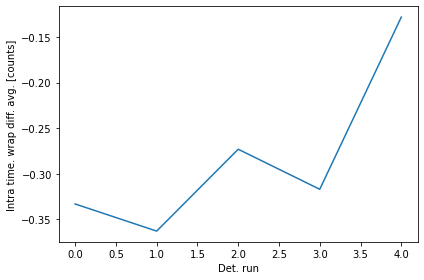

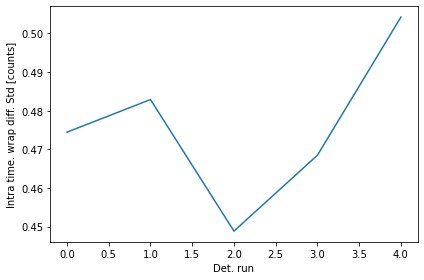

Intra time. wrap diff. avg. [counts]: -0.282852954
Intra time. wrap diff. std [counts]: 0.47577118999999995


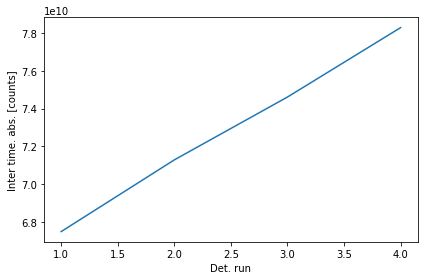

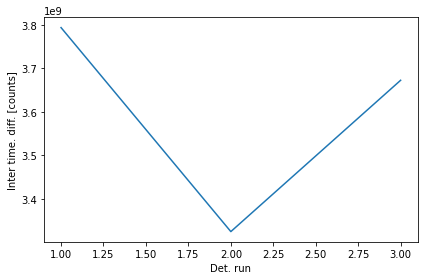

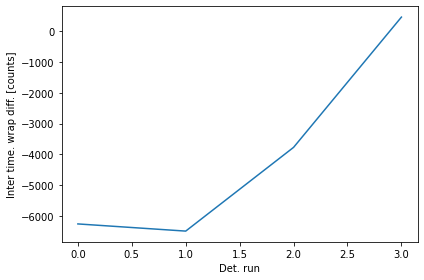

Inter time. wrap diff. avg. [counts]: -4018.0
Inter time. wrap diff. median [counts]: -5017.5
Inter time. wrap diff. std [counts]: 2794.9412


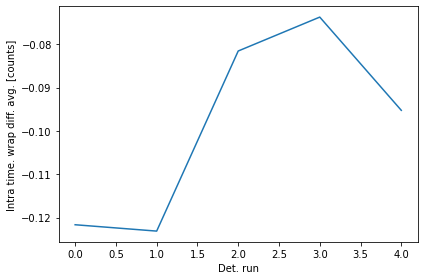

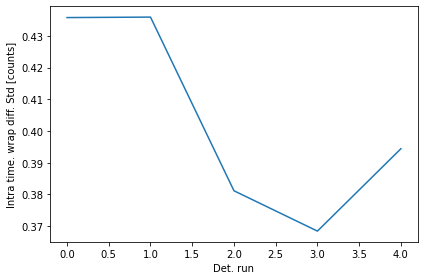

Intra time. wrap diff. avg. [counts]: -0.09907181400000001
Intra time. wrap diff. std [counts]: 0.40313364400000007


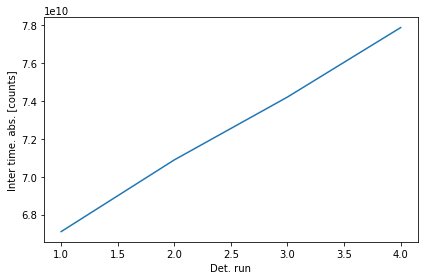

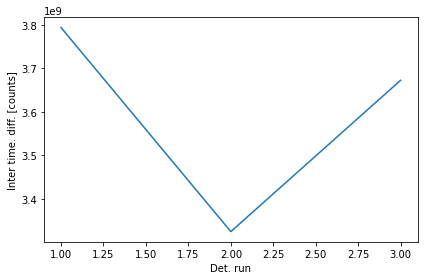

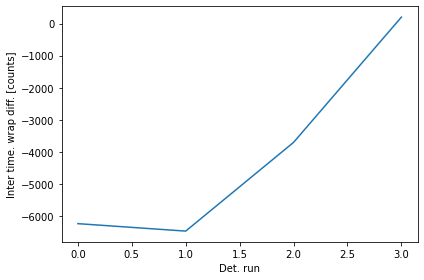

Inter time. wrap diff. avg. [counts]: -4047.0
Inter time. wrap diff. median [counts]: -4964.0
Inter time. wrap diff. std [counts]: 2681.1904


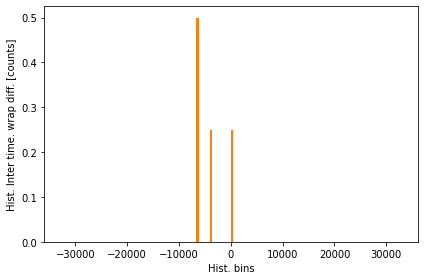

In [36]:
## Synchronization analysis inter and intra runs
# Connect on the timetagg part only channel 1
# It has to be used PRUassTrigSigScriptHist4Sig in PRU1
# Attention TimeTaggsDetAnalytics[5] stores the mean wrap count difference
# Attention TimeTaggsDetAnalytics[6] stores the std wrap count difference
ExtraDetailString='NTP'#'PTPjitter'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=8.0*8192.0# Histogram analysis periodicity
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

#######################################################################################################
#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+0]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

## Zero Time Point
#ListStatisticsTimeTaggDetQubitsNodeParam7=ListStatisticsTimeTaggDetQubitsNodeParam7-ListStatisticsTimeTaggDetQubitsNodeParam7[0]

# Checking with wrapping
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxNode1IntraRunSynchChecker=IntraRunSynchChecker
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

##############################################################################################################
## Node 2
ListNumStoredQubitsNode=np.load(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString+'.npy')
NonZeroIndecesDet=np.where(ListNumStoredQubitsNode>0)[0]
ListStatisticsTimeTaggDetQubitsNodeParam5=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffAvgNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. avg. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=(np.load(pathScriptData+'DealerListNumStoredQubitsTdiffStdNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Intra time. wrap diff. Std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Intra time. wrap diff. avg. [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam5)))
print('Intra time. wrap diff. std [counts]: '+str(np.mean(ListStatisticsTimeTaggDetQubitsNodeParam6)))

#######################################################################################################
#Inter runs checker of the initial detection in channel 1
# The plot below helps adjust the Threshold value (we should a constantly increasing line - never a decrease jump)
# If the first out of place is a up-bump->threshold value too high
# If the first out of place is a down-bump->threshold value too low
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7[1:])
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-2,dtype=np.float32)
for iIter in range(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    IntraRunSynchChecker[iIter-1]=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+0]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

## Zero Time Point
#ListStatisticsTimeTaggDetQubitsNodeParam7=ListStatisticsTimeTaggDetQubitsNodeParam7-ListStatisticsTimeTaggDetQubitsNodeParam7[0]

# Checking with wrapping
ListStatisticsTimeTaggDetQubitsNodeParam7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesDet]
IntraRunSynchChecker=np.zeros(len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,dtype=np.float32)
for iIter in range(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1):    
    CalcAux=ListStatisticsTimeTaggDetQubitsNodeParam7[iIter+1]-ListStatisticsTimeTaggDetQubitsNodeParam7[1*iIter]
    NumCycles=np.round(CalcAux/HistPeriodicityAux)
    IntraRunSynchChecker[iIter]=(np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0)
    #if (iIter>0):
    #    print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[0+0*iIter])
HistAuxNode2IntraRunSynchChecker=IntraRunSynchChecker
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7)-1,1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 16*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist1, bins1 = np.histogram(HistAuxNode1IntraRunSynchChecker, bins=bin_edges, density=True)
hist2, bins2 = np.histogram(HistAuxNode2IntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist1/np.sum(hist1),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.bar(bin_centers, hist2/np.sum(hist2),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
plt.savefig(pathScriptData+'MeasHistSynchTwoChannel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

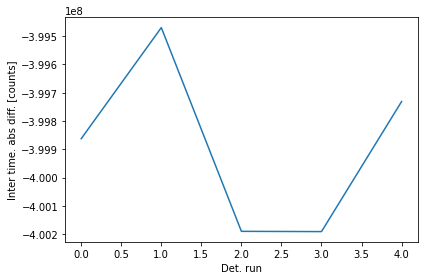

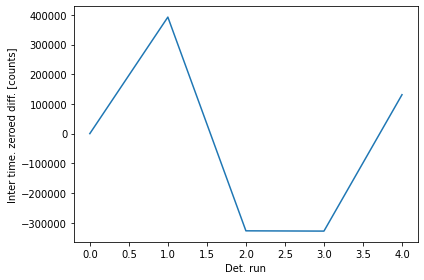

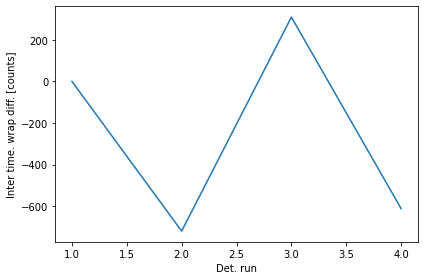

Inter time. wrap diff. avg. [counts]: -255.75
Inter time. wrap diff. median [counts]: -306.0
Inter time. wrap diff. std [counts]: 426.2607


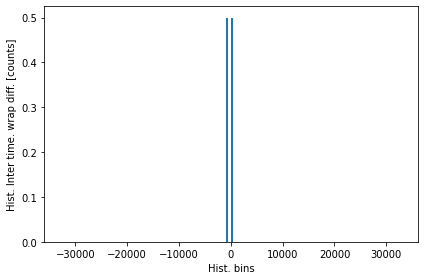

In [33]:
###### Analysis between timetaggs
### Node 1 vs. Node 2
ExtraDetailString='NTP'#'PTPjitter'#'NoPTP'# 'NTP'#'PTP'
HistPeriodicityAux=8.0*8192.0# Histogram analysis periodicity
ListNumStoredQubitsNode1=np.load(pathScriptData+'DealerListNumStoredQubitsNode1'+ExtraDetailString+'.npy')
ListNumStoredQubitsNode2=np.load(pathScriptData+'DealerListNumStoredQubitsNode2'+ExtraDetailString+'.npy')

# Get the detection runs where both detected
NonZeroIndecesNodeDet=np.where((ListNumStoredQubitsNode1 != 0.0) & (ListNumStoredQubitsNode2 != 0.0))[0]

ListStatisticsTimeTaggDetQubitsNode1Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]
ListStatisticsTimeTaggDetQubitsNode2Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]

IntraRunSynchChecker=np.zeros(len(NonZeroIndecesNodeDet),dtype=np.float32)
for iIter in range(0,len(NonZeroIndecesNodeDet),1):  
    IntraRunSynchChecker[iIter]=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(NonZeroIndecesNodeDet),1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. abs diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

# Set 0 time point
ListStatisticsTimeTaggDetQubitsNode1Param7=ListStatisticsTimeTaggDetQubitsNode1Param7-ListStatisticsTimeTaggDetQubitsNode1Param7[0]
ListStatisticsTimeTaggDetQubitsNode2Param7=ListStatisticsTimeTaggDetQubitsNode2Param7-ListStatisticsTimeTaggDetQubitsNode2Param7[0]

IntraRunSynchChecker=np.zeros(len(NonZeroIndecesNodeDet),dtype=np.float32)
for iIter in range(0,len(NonZeroIndecesNodeDet),1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
    IntraRunSynchChecker[iIter]=CalcAux
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(NonZeroIndecesNodeDet),1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. zeroed diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

#print('Inter time. diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
#print('Inter time. diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
#print('Inter time. diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

#ListStatisticsTimeTaggDetQubitsNode1Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode1'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]
#ListStatisticsTimeTaggDetQubitsNode2Param7=(np.load(pathScriptData+'DealerListNumStoredQubitsTabsNode2'+ExtraDetailString+'.npy'))[NonZeroIndecesNodeDet]

IntraRunSynchChecker=np.zeros(len(NonZeroIndecesNodeDet)-1,dtype=np.float32)
for iIter in range(0,len(NonZeroIndecesNodeDet)-1,1):
    CalcAux=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
    #ListStatisticsTimeTaggDetQubitsNode1Param7[iIter+1]=ListStatisticsTimeTaggDetQubitsNode1Param7[iIter+1]-ListStatisticsTimeTaggDetQubitsNode1Param7[iIter]
    #ListStatisticsTimeTaggDetQubitsNode2Param7[iIter+1]=ListStatisticsTimeTaggDetQubitsNode2Param7[iIter+1]-ListStatisticsTimeTaggDetQubitsNode2Param7[iIter]
    IntraRunSynchChecker[iIter]=np.mod(HistPeriodicityAux/2.0+CalcAux,HistPeriodicityAux)-HistPeriodicityAux/2.0
    #if (iIter>0):
    #    #print(IntraRunSynchChecker[iIter]-IntraRunSynchChecker[1*iIter-1])
    #    print(CalcAux)
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(1,len(NonZeroIndecesNodeDet),1),IntraRunSynchChecker)
plt.xlabel('Det. run')
plt.ylabel('Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

print('Inter time. wrap diff. avg. [counts]: '+str(np.mean(IntraRunSynchChecker)))
print('Inter time. wrap diff. median [counts]: '+str(np.median(IntraRunSynchChecker)))
print('Inter time. wrap diff. std [counts]: '+str(np.std(IntraRunSynchChecker)))

# Histogram analysis
# Define the number of bins and periodicity
num_bins = 8
periodicity = HistPeriodicityAux

# Calculate the bins edges
bin_edges = np.linspace(-periodicity/2, periodicity/2, 16*num_bins+1)

# Calculate bin centers from edges for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate histogram data with normalization
hist, bins = np.histogram(IntraRunSynchChecker, bins=bin_edges, density=True)

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
plt.savefig(pathScriptData+'MeasHistSynchInterChannel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

In [ ]:
## Dealer as common node - Entanglement interference analysis
# Only channel 1 is connected
# PRU1 PRUassTrigSigScriptHist4Sig.p is used
# PTP protocol better enabled
# Tags statistics in QPhysLayer c++ is modified to this particular case!

In [13]:
import random
import time
NumTestMax = 5
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
for iIterTest in range(0,NumTestMax,1):
    # Sending Entangled QuBits
    QPLAagent.SimulateRequestMultipleNodesQubitsHost(IPhostClientOpNet,IPhostDealerOpNet,IPhostServerOpNet,IPhostDealerOpNet,IPnodeDealerConNet,IPhostDealerConNet,128) # Request that the other nodes of the specified hosts get ready to receive entangled qubits from the dealer's node
    time.sleep(5.0)# Give time to receive qubits before requesting them
    NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
    StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.double)# equivalnet to float64 for C like arrays
    QPLAagent.SimulateRetrieveNumStoredQubitsNode(IPnodeDealerConNet,IPhostDealerConNet,NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
    ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
    ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
    ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
    ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
    ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
    ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
    ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
    ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(5.0)
    #time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

ListNumStoredQubitsNode: [2048, 2048, 2048, 2048, 2048]
ListStatisticsTimeTaggDetQubitsNodeParam0: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam1: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam2: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam3: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam4: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam5: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam6: [0.0, 0.0, 0.0, 0.0, 0.0]
ListStatisticsTimeTaggDetQubitsNodeParam7: [0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Analysis of interference - Visibility & Coincidence

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
plt.savefig(pathScriptData+'MeasInterferenceVis4Channel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.bar(bin_centers, hist/np.sum(hist),width=(bin_edges[1] - bin_edges[0]))#, density=True)
plt.xlabel('Hist. bins')
plt.ylabel('Hist. Inter time. wrap diff. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
plt.savefig(pathScriptData+'MeasInterferenceCoincidence4Channel.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()